In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import Optional
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm.notebook import tqdm

from sklearn.cluster import KMeans

from myutils.stats import corrcoef, acfunc
from myutils.matplotlib import matplotlib_seaborn_style

from src.rzd import PlacePriceModel

matplotlib_seaborn_style()

In [3]:
results_dir = Path('../data/weekends')
results_dir.mkdir(exist_ok=True)

figures_dir = results_dir / 'figures'
figures_dir.mkdir(exist_ok=True)

In [4]:
data = pd.read_csv('../data/data.csv', parse_dates=['date'], encoding='utf-8')

data['weekday'] = data['date'].dt.weekday
data['day_name'] = data['date'].dt.day_name()

weekdays = data[['weekday', 'day_name']].drop_duplicates().sort_values(by='weekday')\
    .set_index('weekday')['day_name'].to_dict()

data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour,places_frac,weekday,day_name
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,Monday
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,1,Tuesday


In [5]:
trains = sorted(data['train'].unique().tolist())
len(trains)

94

In [6]:
maxdays = 30

In [7]:
models = {}
metrics = []

for train in tqdm(trains):
    train_data = data[(data['train'] == train) & (data['days'] <= maxdays)]

    places = train_data.pivot(index='date', columns='days', values='places_frac')
    prices = train_data.pivot(index='date', columns='days', values='price')
    
    model = PlacePriceModel()
    
    try:
        model.fit(places, prices)
        models[train] = model
        
        train_num, train_class = train.split('-')
        metrics.append((train_num, train_class, model.explained_variance, model.r2))
        
    except Exception as e:
        print(train, e)
    
metrics = pd.DataFrame(metrics, columns=['num', 'class', 'explained', 'r2'])
metrics['train'] = metrics['num'] + '-' + metrics['class']

metrics.to_csv(results_dir / 'model_metrics.csv', index=False)

metrics.head()

  0%|          | 0/94 [00:00<?, ?it/s]

,num,class,explained,r2,train
0,001А,Купе,0.792619,0.153085,001А-Купе
1,002А,Купе,0.814872,0.226177,002А-Купе
2,005А,СВ,0.844456,0.154320,005А-СВ
3,006А,СВ,0.849035,0.172454,006А-СВ
4,701Н,СВ,0.700852,0.165152,701Н-СВ


<AxesSubplot:xlabel='explained', ylabel='r2'>

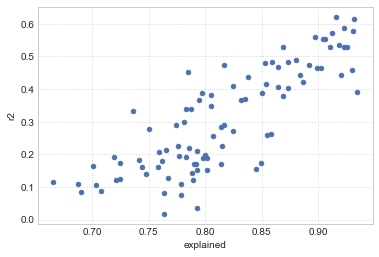

In [8]:
metrics.plot(kind='scatter', x='explained', y='r2')

In [9]:
a = pd.DataFrame({train: model.a for train, model in models.items()})

a.head(2)

,001А-Купе,002А-Купе,005А-СВ,006А-СВ,701Н-СВ,701Н-Сидячий,703Н-СВ,703Н-Сидячий,705Н-СВ,705Н-Сидячий,...,778А-C1,778А-C2,779А-B1,779А-B2,779А-C1,779А-C2,780А-B1,780А-B2,780А-C1,780А-C2
date,,,,,,,,,,,,,,,,,,,,,
2021-04-12,0.226759,1.103916,0.212127,1.450984,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.462985,0.377123,0.363662,1.099779,0.489072,0.778713,-0.468399,1.029120,0.634961,1.084068
2021-04-13,0.045939,1.233312,0.811963,1.153781,NaN,0.323314,1.282096,1.436808,NaN,NaN,...,-2.670138,-0.436191,0.358688,1.254636,0.705196,1.022962,-0.480983,0.246797,-0.438163,0.646559


In [11]:
df = {}

for train in a.columns:
    ts = a[train].copy()
    assert abs(ts.mean()) < 1e-8
    ts /= ts.std()
    
    ts.index = ts.index.day_name()
    
    df[train] = ts.groupby(level=0).mean()
    
df = pd.DataFrame(df).reindex(weekdays.values()).T

df.columns.name = None
df.index.name = 'train'

df.to_csv(results_dir / 'weekly_avg_pcs.csv')

df.head(2)

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
train,,,,,,,
001А-Купе,0.413662,0.676598,0.416420,0.542463,-0.672912,-0.285485,-1.180378
002А-Купе,0.780929,0.440503,0.551972,-0.670010,-0.673684,0.049775,-0.438934


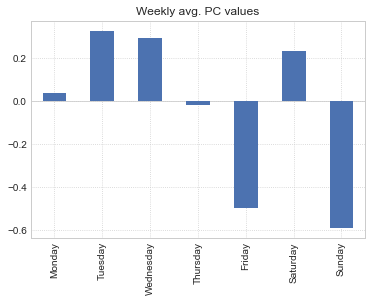

In [12]:
df.T.mean(axis=1).plot(kind='bar')
plt.axhline(lw=0.8, c='.8').set_zorder(0)

plt.title('Weekly avg. PC values')
plt.savefig(figures_dir / 'weekly_avg_pcs_total.pdf', transparent=True, bbox_inches='tight')

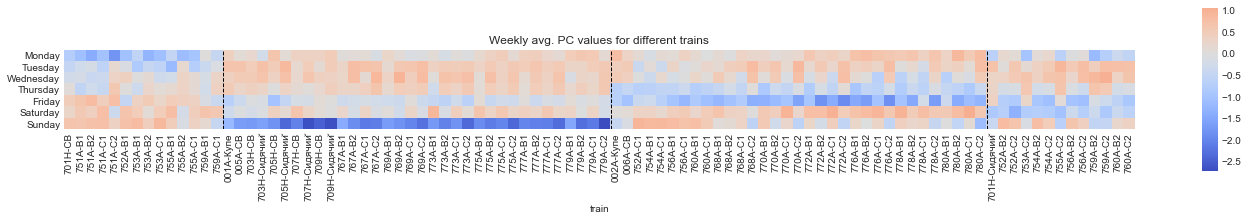

In [18]:
k = 4

kmeans = KMeans(n_clusters=k, random_state=6)

clusters = pd.DataFrame({'cluster': kmeans.fit_predict(df.values)}, index=df.index)

idx = clusters.reset_index().sort_values(by=['cluster', 'train']).set_index('train').index

clusters = clusters.loc[idx]
df = df.loc[idx]

plt.figure(figsize=(24, 3))

sns.heatmap(df.T, square=True, xticklabels=True, cmap='coolwarm', center=0, cbar_kws={'aspect': 10})

for n in clusters['cluster'].value_counts().sort_index().cumsum():
    plt.axvline(n, lw=1, c='k', ls='dashed')

plt.title('Weekly avg. PC values for different trains')
plt.savefig(figures_dir / 'weekly_avg_pcs.pdf', transparent=True, bbox_inches='tight')

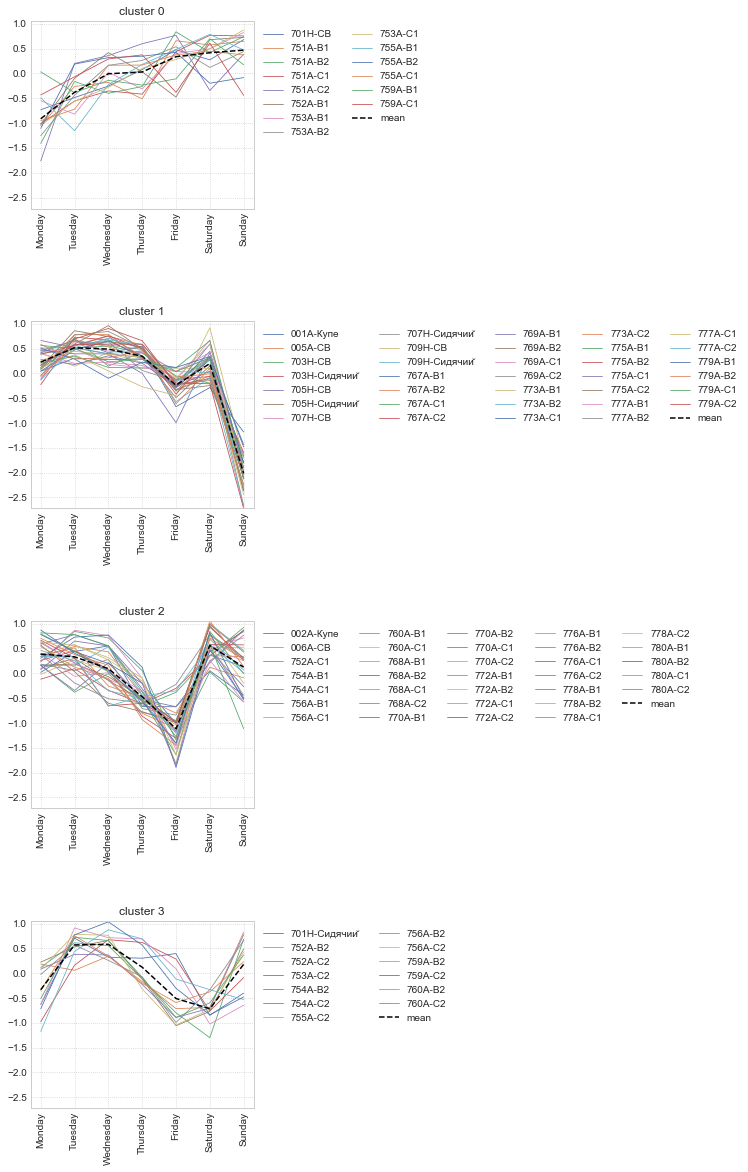

In [19]:
nrows = k

fig, axes = plt.subplots(nrows=nrows)
fig.set_size_inches(4, 5 * nrows)
fig.subplots_adjust(hspace=0.6)

vmin = df.min().min()
vmax = df.max().max()

for cluster, ax in zip(np.unique(clusters['cluster']), axes):
    df_ = df[clusters['cluster'] == cluster]
    
    df_.T.plot(ax=ax, lw=0.8)
    
    df_.mean().plot(ax=ax, c='k', ls='dashed', label='mean')

    ax.legend().set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=df_.shape[0] // 8 + 1)
    ax.set_ylim(vmin, vmax)
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(f'cluster {cluster}')
    
plt.savefig(figures_dir / 'weekly_avg_pc_clusters.pdf', transparent=True, bbox_inches='tight')

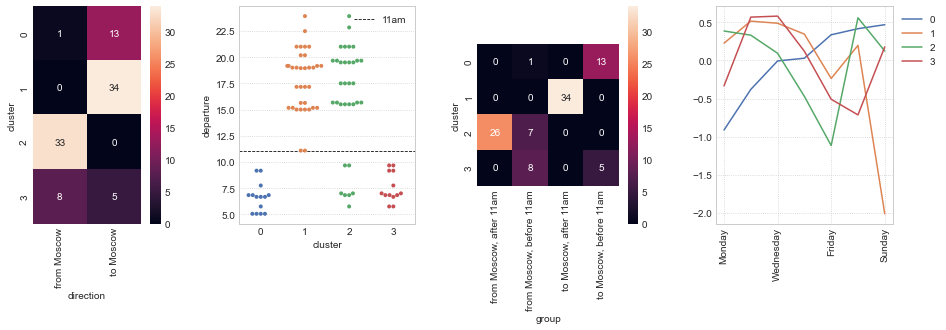

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)
fig.set_size_inches(16, 4)
fig.subplots_adjust(wspace=0.35)

clusters['direction'] = clusters.index.map(
    lambda s: 'from Moscow' if int(s.split('-')[0][:-1]) % 2 == 0 else 'to Moscow')

sns.heatmap(pd.crosstab(clusters['cluster'], clusters['direction']), ax=ax1, square=True, annot=True)
ax1.tick_params(axis='x', rotation=90)

clusters['departure'] = data.drop_duplicates('train')\
    .set_index('train')[['departure_hour']]

th = 11

clusters['departs'] = clusters['departure'].apply(
    lambda h: f'before {th}am' if h <= th else f'after {th}am')

sns.swarmplot(data=clusters, x='cluster', y='departure', size=4, ax=ax2)
ax2.axhline(th, c='k', ls='dashed', lw=0.8, label=f'{th}am')
ax2.legend()

clusters['group'] = clusters['direction'] + ', ' + clusters['departs']

sns.heatmap(pd.crosstab(clusters['cluster'], clusters['group']), ax=ax3, square=True, annot=True)

grp = df.copy()
grp['cluster'] = clusters['cluster']

grp = grp.groupby('cluster').mean()

#ax4.plot(grp.T)
grp.T.plot(ax=ax4)
ax4.tick_params(axis='x', rotation=90)
ax4.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(figures_dir / 'explaining_weekly_avg_pc_clusters.pdf', transparent=True, bbox_inches='tight')

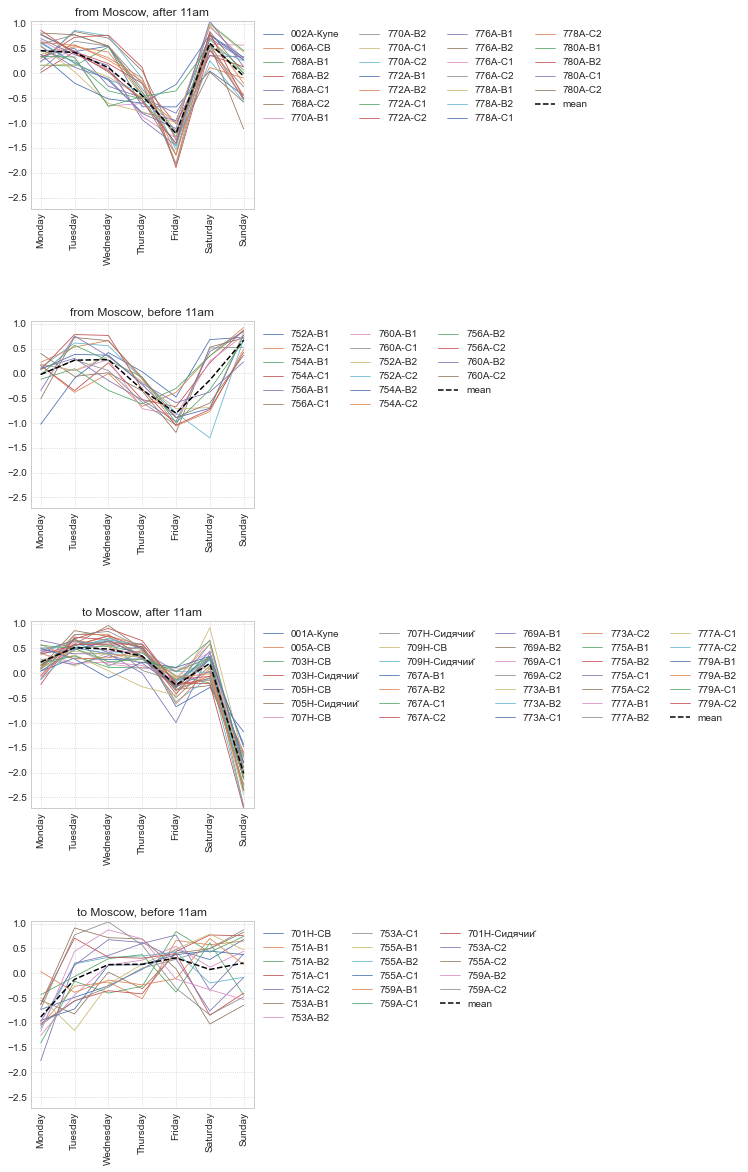

In [21]:
nrows = k

fig, axes = plt.subplots(nrows=nrows)
fig.set_size_inches(4, 5 * nrows)
fig.subplots_adjust(hspace=0.6)

vmin = df.min().min()
vmax = df.max().max()

for cluster, ax in zip(np.unique(clusters['group']), axes):
    df_ = df[clusters['group'] == cluster]
    
    df_.T.plot(ax=ax, lw=0.8)
    
    df_.mean().plot(ax=ax, c='k', ls='dashed', label='mean')

    ax.legend().set_visible(False)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=df_.shape[0] // 8 + 1)
    ax.set_ylim(vmin, vmax)
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(cluster)
    
plt.savefig(figures_dir / 'weekly_avg_pc_groups.pdf', transparent=True, bbox_inches='tight')

In [23]:
clusters['weekends'] = clusters['cluster'].apply(cluster_weekends.get)

clusters.head(2)

,cluster,direction,departure,departs,group,weekends
train,,,,,,
701Н-СВ,0,to Moscow,7.75,before 11am,"to Moscow, before 11am",[0]
751А-B1,0,to Moscow,5.05,before 11am,"to Moscow, before 11am",[0]


In [24]:
clusters.to_csv(results_dir / 'weekly_avg_pc_clusters.csv')

In [25]:
data['weekend'] = 0

for train, row in clusters.iterrows():
    weekends = row['weekends']
    
    mask = (data['train'] == train) & data['weekday'].isin(weekends)
    data.loc[mask, 'weekend'] = 1
    
data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour,places_frac,weekday,day_name,weekend
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,Monday,0
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,1,Tuesday,0


In [26]:
days_thres = 10

data['short_term'] = (data['days'] <= days_thres).astype(int)

data.head(2)

,date,days,places,price,num,class,train,departure_hour,arrival_hour,places_frac,weekday,day_name,weekend,short_term
0,2021-04-12,1,28.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.200000,0,Monday,0,1
1,2021-04-13,1,52.0,3790.0,001А,Купе,001А-Купе,23.916667,7.916667,0.371429,1,Tuesday,0,1


In [27]:
data.drop(columns=['weekday', 'day_name']).to_csv('../data/data.csv', index=False)

In [28]:
!jupyter nbconvert --to html weekends.ipynb

[NbConvertApp] Converting notebook weekends.ipynb to html
[NbConvertApp] Writing 1076612 bytes to weekends.html
